## Use this section to evaluate model

In [ ]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def calculate_map_recall(ground_truth_json, predictions_json):
    # Load ground truth and predictions
    coco_gt = COCO(ground_truth_json)
    coco_dt = coco_gt.loadRes(predictions_json)
    
    # Initialize COCOeval object
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    
    # Run evaluation
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Extract MAP and Recall
    map_score = coco_eval.stats[1]  # AP IoU=0.50:0.95 area=all maxDets=100
    recall_score = coco_eval.stats[8]  # AR IoU=0.50:0.95 area=all maxDets=100
    
    return map_score, recall_score

# Example usage
ground_truth_json = 'ground_truth/annotations_2560x1440.json'
predictions_json = 'predictions/filtered_predictions_1440p.json'

map_score, recall_score = calculate_map_recall(ground_truth_json, predictions_json)
print(f"Mean Average Precision (MAP): {map_score}")
print(f"Recall: {recall_score}")


In [ ]:
map_score

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def plot_distribution_for_detected_objects(ground_truth_json, predictions_json):
    """
    Function which plots a distribution for the number of detected objects per image, giving a bar for each class.

    Args:
        ground_truth_json: Path to the ground truth JSON file.
        predictions_json: Path to the predictions JSON file.
    """

    # Load ground truth and predictions
    coco_gt = COCO(ground_truth_json)
    coco_dt = coco_gt.loadRes(predictions_json)

    # Initialize COCOeval object
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')

    # Run evaluation
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Extract category information
    categories = coco_gt.loadCats(coco_gt.getCatIds())
    cat_id_to_name = {cat['id']: cat['name'] for cat in categories}

    # Count number of detected objects per class
    detections = defaultdict(int)
    for ann in coco_dt.anns.values():
        detections[ann['category_id']] += 1

    # Prepare data for plotting
    class_names = [cat_id_to_name[cat_id] for cat_id in detections.keys()]
    counts = [detections[cat_id] for cat_id in detections.keys()]

    # Plot the distribution using Seaborn
    plt.figure(figsize=(12, 8))
    sns.barplot(x=class_names, y=counts, palette="viridis")
    plt.xlabel('Class')
    plt.ylabel('Number of Detected Objects')
    plt.title('Distribution of Detected Objects by Class')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage
ground_truth_json = 'ground_truth/annotations_3840x2160.json'
predictions_json = 'predictions/DETR/predictions_2160p.json'

plot_distribution_for_detected_objects(ground_truth_json, predictions_json)


In [ ]:
import json
from pycocotools.coco import COCO

def compare_image_ids(ground_truth_json, predictions_json):
    # Load ground truth
    coco_gt = COCO(ground_truth_json)
    
    # Load predictions
    with open(predictions_json, 'r') as f:
        predictions_data = json.load(f)
    
    gt_image_ids = set(coco_gt.getImgIds())
    dt_image_ids = set(pred['image_id'] for pred in predictions_data)
    
    missing_in_predictions = gt_image_ids - dt_image_ids
    extra_in_predictions = dt_image_ids - gt_image_ids
    
    if missing_in_predictions:
        print(f"Missing Image IDs in Predictions: {sorted(missing_in_predictions)}")
    else:
        print("No missing Image IDs in Predictions.")
    
    if extra_in_predictions:
        print(f"Extra Image IDs in Predictions: {sorted(extra_in_predictions)}")
    else:
        print("No extra Image IDs in Predictions.")

# Example usage
ground_truth_json = 'ground_truth/annotations_2560x1440.json'
predictions_json = 'predictions/predictions_1440p.json'

compare_image_ids(ground_truth_json, predictions_json)


<h2>Use this section to check that the BBOX from the ground truth are correct</h2>

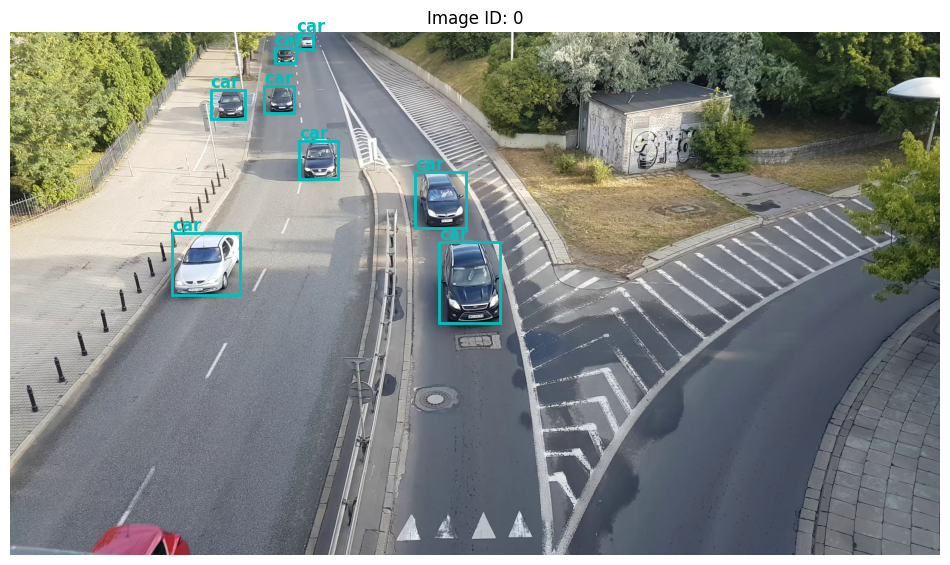

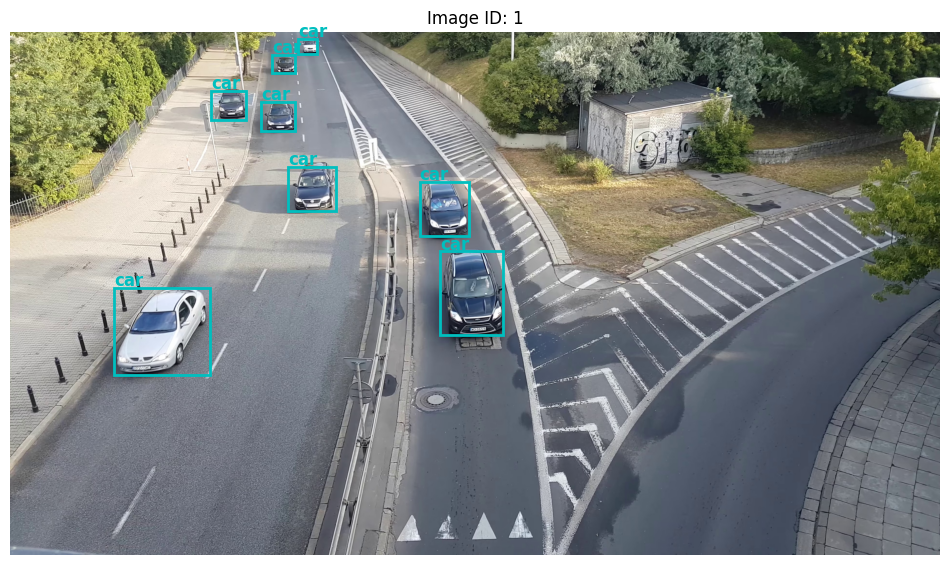

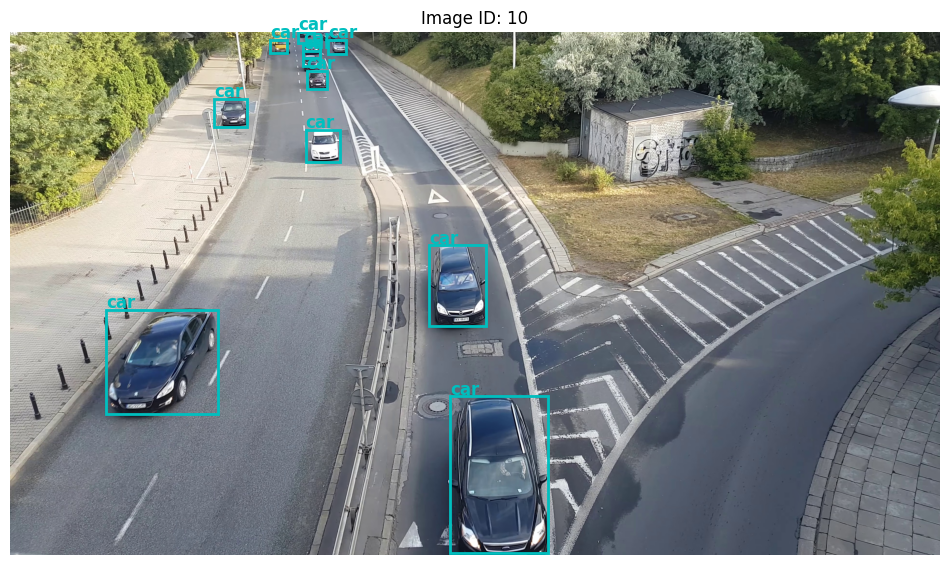

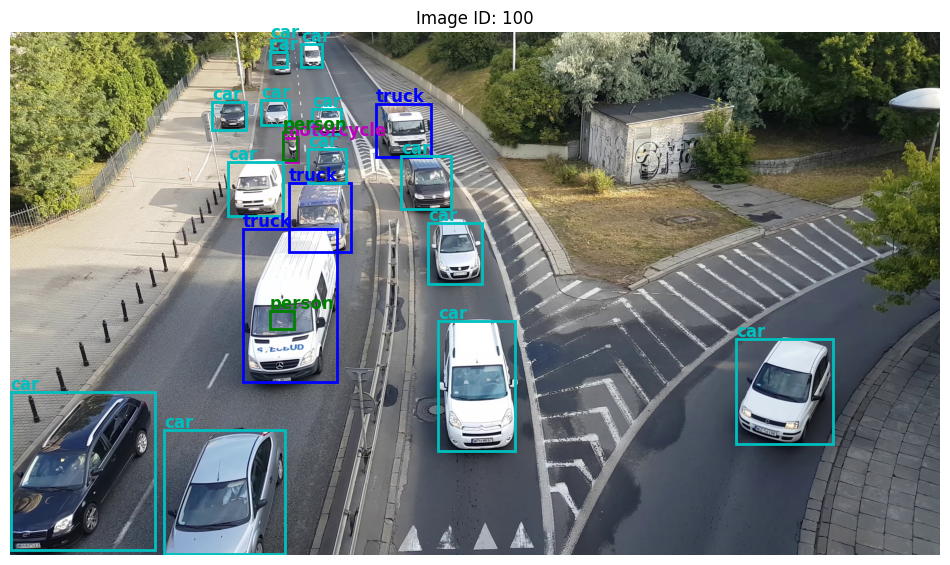

KeyboardInterrupt: 

In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

def display_images_with_bboxes(ground_truth_json, images_folder):
    # Load ground truth JSON
    with open(ground_truth_json, 'r') as f:
        data = json.load(f)
    
    images_data = {img['id']: img for img in data['images']}
    annotations_data = data['annotations']
    categories = {cat['id']: cat['name'] for cat in data['categories']}
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    
    # Group annotations by image_id
    annotations_by_image = {}
    for annotation in annotations_data:
        image_id = annotation['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(annotation)
    
    for image_id, annotations in annotations_by_image.items():
        image_info = images_data[image_id]
        image_path = os.path.join(images_folder, image_info['file_name'])
        # Set the image path to find the jpg extesnion and remove everything after it
        # image_path = image_path.split('_jpg')[0] + '.jpg'
        
        # Open image
        image = Image.open(image_path)
        fig, ax = plt.subplots(1, figsize=(12, 8))
        ax.imshow(image)
        
        # Draw bounding boxes and labels
        for annotation in annotations:
            bbox = annotation['bbox']
            category_id = annotation['category_id']
            label = categories[category_id]
            
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=2, edgecolor=colors[category_id % len(colors)], facecolor='none'
            )
            ax.add_patch(rect)
            plt.text(bbox[0], bbox[1] - 10, label, color=colors[category_id % len(colors)], fontsize=12, weight='bold')
        
        plt.title(f"Image ID: {image_id}")
        plt.axis('off')
        plt.show()


# Example usage
ground_truth_json = 'predictions/DETR/predictions_2160p.json'#'ground_truth/annotations_3840x2160.json' #'_annotations.coco.json'
images_folder = 'frames/2160p'  # Replace with the path to the folder containing images
display_images_with_bboxes(ground_truth_json, images_folder)


In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

def display_images_with_bboxes(ground_truth_json, prediction_json, images_folder):
    # Load ground truth JSON
    with open(ground_truth_json, 'r') as f:
        gt_data = json.load(f)
    
    # Load prediction JSON
    with open(prediction_json, 'r') as f:
        pred_data = json.load(f)
    
    images_data = {img['id']: img for img in gt_data['images']}
    gt_annotations_data = gt_data['annotations']
    categories = {cat['id']: cat['name'] for cat in gt_data['categories']}
    
    # Group ground truth annotations by image_id
    gt_annotations_by_image = {}
    for annotation in gt_annotations_data:
        image_id = annotation['image_id']
        if image_id not in gt_annotations_by_image:
            gt_annotations_by_image[image_id] = []
        gt_annotations_by_image[image_id].append(annotation)
    
    # Group predictions by image_id
    pred_annotations_by_image = {}
    for annotation in pred_data:
        image_id = annotation['image_id']
        if image_id not in pred_annotations_by_image:
            pred_annotations_by_image[image_id] = []
        pred_annotations_by_image[image_id].append(annotation)
    
    for image_id, gt_annotations in gt_annotations_by_image.items():
        image_info = images_data[image_id]
        image_path = os.path.join(images_folder, image_info['file_name'])
        
        # Open image
        image = Image.open(image_path)
        fig, ax = plt.subplots(1, figsize=(12, 8))
        ax.imshow(image)
        
        # Draw ground truth bounding boxes in red
        for annotation in gt_annotations:
            bbox = annotation['bbox']
            category_id = annotation['category_id']
            label = categories[category_id]
            
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            plt.text(bbox[0], bbox[1] - 10, label, color='red', fontsize=12, weight='bold')
        
        # Draw prediction bounding boxes in green
        if image_id in pred_annotations_by_image:
            pred_annotations = pred_annotations_by_image[image_id]
            for annotation in pred_annotations:
                bbox = annotation['bbox']
                category_id = annotation['category_id']
                label = categories[category_id] if category_id in categories else "unknown"
                
                rect = patches.Rectangle(
                    (bbox[0], bbox[1]), bbox[2], bbox[3],
                    linewidth=2, edgecolor='g', facecolor='none'
                )
                ax.add_patch(rect)
                plt.text(bbox[0], bbox[1] - 10, label, color='green', fontsize=12, weight='bold')
        
        plt.title(f"Image ID: {image_id}")
        plt.axis('off')
        plt.show()


# Example usage
ground_truth_json = 'ground_truth/annotations_2560x1440.json'
prediction_json = 'updated_predictions/predictions_1440p.json'
images_folder = 'frames/1440p'  # Replace with the path to the folder containing images
display_images_with_bboxes(ground_truth_json, prediction_json, images_folder)


<h2>Resize annotation for different resolutions</h2>

In [ ]:
import json
import os

def resize_annotations(original_bbox, original_size, new_size):
    x_scale = new_size[0] / original_size[0]
    y_scale = new_size[1] / original_size[1]
    x, y, width, height = original_bbox
    new_bbox = [x * x_scale, y * y_scale, width * x_scale, height * y_scale]
    return new_bbox

def resize_annotations_only(ground_truth_json, output_folder, target_sizes):
    with open(ground_truth_json, 'r') as f:
        data = json.load(f)
    
    original_width, original_height = 3840, 2160  # Assuming 4K resolution
    
    for target_size in target_sizes:
        width, height = target_size
        new_data = data.copy()
        new_data['images'] = []
        new_data['annotations'] = []
        
        for img in data['images']:
            new_img = img.copy()
            new_img['width'] = width
            new_img['height'] = height
            new_data['images'].append(new_img)
            
            for ann in data['annotations']:
                if ann['image_id'] == img['id']:
                    new_ann = ann.copy()
                    new_ann['bbox'] = resize_annotations(ann['bbox'], (original_width, original_height), (width, height))
                    new_data['annotations'].append(new_ann)
        
        resized_annotation_path = os.path.join(output_folder, f"annotations_{width}x{height}.json")
        os.makedirs(output_folder, exist_ok=True)
        with open(resized_annotation_path, 'w') as f:
            json.dump(new_data, f, indent=4)
        
        print(f"Resized annotations saved for {width}x{height}")

# Example usage
ground_truth_json = 'ground_truth/ground_truth.json'
output_folder = 'ground_truth/'  # Replace with the path to the folder for saving resized annotations
target_sizes = [(3840, 2160), (2560, 1440), (1920, 1080), (1280, 720), (854, 480), (640, 360)]

resize_annotations_only(ground_truth_json, output_folder, target_sizes)


In [ ]:
import json
import csv

# Function to extract the required part of the file name and adjust the format
def extract_base_name(file_name):
    base_name = file_name.split('.rf.')[0]
    return base_name.replace('_jpg', '.jpg')

# Load the original dataset
with open('_annotations.coco.json', 'r') as file:
    data = json.load(file)

# Create a mapping from image ID to the adjusted base name
image_id_to_name = {
    image['id']: extract_base_name(image['file_name']) for image in data['images']
}

# Extract license plate annotations
license_plate_annotations = [
    {
        'ImageName': image_id_to_name[annotation['image_id']],
        'x': annotation['bbox'][0],
        'y': annotation['bbox'][1],
        'width': annotation['bbox'][2],
        'height': annotation['bbox'][3],
        'label': ''
    }
    for annotation in data['annotations'] if annotation['category_id'] == 3
]

# Save to CSV
with open('license_plate_annotations.csv', 'w', newline='') as csvfile:
    fieldnames = ['ImageName', 'x', 'y', 'width', 'height', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for item in license_plate_annotations:
        writer.writerow(item)

print("CSV file created successfully!")